iter:50 training loss: 0.4974067509174347, val loss: 0.559149444103241
iter:100 training loss: 0.35534030199050903, val loss: 0.3519388735294342
iter:150 training loss: 0.29193416237831116, val loss: 0.340802937746048
iter:200 training loss: 0.3260316848754883, val loss: 0.3007284700870514
iter:250 training loss: 0.2901226282119751, val loss: 0.2922416031360626
iter:300 training loss: 0.2411552369594574, val loss: 0.2522304058074951
iter:350 training loss: 0.27364253997802734, val loss: 0.2697625756263733
iter:400 training loss: 0.24001285433769226, val loss: 0.2593929171562195
iter:450 training loss: 0.22495383024215698, val loss: 0.2555948495864868
iter:500 training loss: 0.22170469164848328, val loss: 0.23119014501571655
iter:550 training loss: 0.19536477327346802, val loss: 0.22334648668766022
iter:600 training loss: 0.19095337390899658, val loss: 0.2240855097770691
iter:650 training loss: 0.17785753309726715, val loss: 0.1899580955505371
iter:700 training loss: 0.22288891673088074

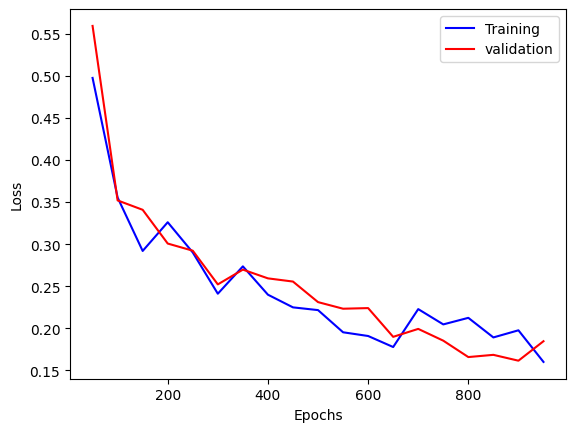

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from utils import *


def sample_data(split = 'train'):
    if split == 'train':
        data =  training_dataset
    else:
        data = validation_dataset
    
    ix = torch.randperm(data.shape[0])[:batch_size]
    
    return data[ix]

learning_rate = 0.01
max_iters = 1000
batch_size = 32

iters = []
loss_value = []
val_loss_value = []

dataset = torch.load("data/hidden.pt")
dataset_size = dataset.shape[0]
training_dataset = dataset[:int(dataset_size*0.5)]
validation_dataset = dataset[int(dataset_size*0.5):]
model = SAE(SAE_Config())

LOAD_MODEL = False
PATH = "models/basic_linear_0.99.bin"
if LOAD_MODEL:
    model = SAE(SAE_Config())
    model.load_state_dict(torch.load(PATH))
    model.eval()
else:
    optimizer = torch.optim.Adam(model.parameters() , learning_rate, weight_decay= 1e-5)
    start_time = time.time()
    step_value = max_iters/20
    for i in range(1, max_iters):
        X= sample_data()
        _, loss,_ = model(X)
    
        if i%step_value ==0 :
            model.eval()
            with torch.no_grad():
                X_V = sample_data(split= 'val')
                _, val_loss, _ = model(X_V)
                iters.append(i)
                loss_value.append(loss.item())
                val_loss_value.append(val_loss.item())
                print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
            model.train()

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()


    end_time = time.time()
    print(f"Took {end_time-start_time}s for {max_iters} epochs")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(iters,loss_value, color='blue', label="Training")
    plt.plot(iters, val_loss_value, "red", label = "validation")
    plt.legend()



        






In [30]:


_, _, hidden = model(training_dataset)

In [31]:
(hidden>0).sum(-1).float().mean()

tensor(3.2040)

In [34]:
(hidden>0.1).sum(0)

tensor([    0,     0,     0,     0,     0,     0, 26009,     0, 39373,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0, 14221,     0,     0,
            0, 20533,     0,     0,     0,     1, 21359,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [5]:
hidden.shape

torch.Size([163840, 50])

In [5]:
hidden.max()

tensor(0.3301, grad_fn=<MaxBackward1>)

In [35]:
sp = SuperpositionModel(SuperPositionConfig())
PATH = "models/superpositon.pt"
sp.load_state_dict(torch.load(PATH))
sp.eval()

SuperpositionModel(
  (encoder): Linear(in_features=20, out_features=5, bias=False)
  (decoder): Linear(in_features=5, out_features=20, bias=True)
  (relu): ReLU()
)

In [36]:
original_data  = torch.load("data/original.pt")

In [37]:
logits, loss, hidden = sp(original_data, original_data)

In [38]:
_,_, latents = model(hidden)

In [39]:
hidden.shape, loss, latents.shape, original_data.shape

(torch.Size([327680, 5]),
 tensor(0.0131, grad_fn=<MeanBackward0>),
 torch.Size([327680, 50]),
 torch.Size([327680, 20]))

In [40]:
freqs = (latents>0).sum(0)
freqs

tensor([     0,      0,      0,     41,     18,      0, 242298,      0, 258601,
             0,      0,     44,      9,      0,      3,      5,     40,      0,
             0,      0,      2,     34,      0,      6,      2,      0,      0,
        271199,      0,     23,     12, 127730,      1,      0,      0,     36,
        149609,      0,      0,      7,    118,      0,     37,      0,      0,
             0,     62,      0,     28,      0])

In [44]:
for i in range(50):
   indices = latents[:, i] > 0.01
   x =  original_data[indices]
   _, loss, _ = sp(x, x)
   if freqs[i] and loss.item():
      print(i, loss.item(), freqs[i].item())

   

3 0.0161320548504591 41
4 0.01600298099219799 18
6 0.01312078908085823 242298
8 0.013139030896127224 258601
11 0.020852692425251007 44
12 0.012128854170441628 9
14 nan 3
15 0.018846791237592697 5
16 0.014493751339614391 40
20 nan 2
21 0.010865742340683937 34
23 0.024118278175592422 6
24 nan 2
27 0.013137733563780785 271199
29 0.012850917875766754 23
30 0.01273015420883894 12
31 0.013175594620406628 127730
32 nan 1
35 0.01442005205899477 36
36 0.013099451549351215 149609
39 0.018324416130781174 7
40 0.013241808861494064 118
42 0.01209314726293087 37
46 0.014084906317293644 62
48 0.012054823338985443 28


In [28]:
original_data[0]

tensor([0.0000, 0.0000, 0.6271, 0.0000, 0.0000, 0.0000, 0.0000, 0.2013, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

In [46]:


def get_reconstructed_loss(sp : SuperpositionModel, model : SAE, data: torch.Tensor):
    _, original_loss, _ = sp(data, data)
    _, new_loss, _ = sp(data, data, sae = model)
    ablated = (data**2).sum(-1).mean(0)
    print (f"reconstructed loss {new_loss}, original {original_loss}. Percentage {(ablated-new_loss)*100/(ablated - original_loss)}%")
get_reconstructed_loss(sp, model, original_data)

TypeError: SuperpositionModel.forward() got an unexpected keyword argument 'sae'